**Import all the neccessary libraries**


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


**Hardware Check (GPU)**

In [8]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


**Data Access**

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Load Dataset**

In [10]:
df = pd.read_csv("/content/drive/MyDrive/load_forecasting_dataset_corrected.csv")

**Parse Timestamp and Resample to Hourly**

In [11]:

df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
df = df.dropna(subset=["Timestamp"]).sort_values("Timestamp").reset_index(drop=True)


df = df.set_index("Timestamp")

load_col = "Load Demand (kW)"
weather_cols = [
    "Temperature (°C)", "Humidity (%)", "Wind Speed (m/s)",
    "Rainfall (mm)", "Solar Irradiance (W/m²)"
]


# - use max for event indicator (if any 15-min in hour had event -> hour event = 1)
df_hour = pd.DataFrame()
df_hour[load_col] = df[load_col].resample("H").mean()
for c in weather_cols:
    df_hour[c] = df[c].resample("H").mean()

if "Public Event" in df.columns:
    df_hour["Public Event"] = df["Public Event"].resample("H").max()
else:
    df_hour["Public Event"] = 0


df_hour = df_hour.interpolate(method="time").dropna()

df_hour.head(), df_hour.shape


/tmp/ipython-input-1931971100.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hour[load_col] = df[load_col].resample("H").mean()
/tmp/ipython-input-1931971100.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hour[c] = df[c].resample("H").mean()
/tmp/ipython-input-1931971100.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hour[c] = df[c].resample("H").mean()
/tmp/ipython-input-1931971100.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hour[c] = df[c].resample("H").mean()
/tmp/ipython-input-1931971100.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hour[c] = df[c].resample("H").mean()
/tmp/ipython-input-1931971100.py:18: FutureWarning: 'H' is deprecated and will be removed in a future

(                     Load Demand (kW)  Temperature (°C)  Humidity (%)  \
 Timestamp                                                               
 2020-01-01 00:00:00       1626.458413         29.264584     78.596059   
 2020-01-01 01:00:00       1593.917861         28.939179     78.981324   
 2020-01-01 02:00:00       1457.196911         27.571969     77.364594   
 2020-01-01 03:00:00       1302.073833         26.020738     79.678678   
 2020-01-01 04:00:00       1349.054422         26.490544     80.105671   
 
                      Wind Speed (m/s)  Rainfall (mm)  Solar Irradiance (W/m²)  \
 Timestamp                                                                       
 2020-01-01 00:00:00          2.010490       4.722857               283.256083   
 2020-01-01 01:00:00          2.017491       3.804590               229.819735   
 2020-01-01 02:00:00          1.972281       5.686889               263.726759   
 2020-01-01 03:00:00          1.615092       5.024458               25

**Feature Engineering: Time and Cyclic Encodings**

In [12]:
df_hour = df_hour.reset_index().rename(columns={"Timestamp":"timestamp"})
df_hour["hour"] = df_hour["timestamp"].dt.hour
df_hour["dayofweek"] = df_hour["timestamp"].dt.dayofweek
df_hour["month"] = df_hour["timestamp"].dt.month


df_hour["hour_sin"] = np.sin(2*np.pi*df_hour["hour"]/24)
df_hour["hour_cos"] = np.cos(2*np.pi*df_hour["hour"]/24)

df_hour["dow_sin"] = np.sin(2*np.pi*df_hour["dayofweek"]/7)
df_hour["dow_cos"] = np.cos(2*np.pi*df_hour["dayofweek"]/7)

df_hour["month_sin"] = np.sin(2*np.pi*df_hour["month"]/12)
df_hour["month_cos"] = np.cos(2*np.pi*df_hour["month"]/12)

df_hour.head()


,timestamp,Load Demand (kW),Temperature (°C),Humidity (%),Wind Speed (m/s),Rainfall (mm),Solar Irradiance (W/m²),Public Event,hour,dayofweek,month,hour_sin,hour_cos,dow_sin,dow_cos,month_sin,month_cos
0,2020-01-01 00:00:00,1626.458413,29.264584,78.596059,2.010490,4.722857,283.256083,1,0,2,1,0.000000,1.000000,0.974928,-0.222521,0.5,0.866025
1,2020-01-01 01:00:00,1593.917861,28.939179,78.981324,2.017491,3.804590,229.819735,0,1,2,1,0.258819,0.965926,0.974928,-0.222521,0.5,0.866025
2,2020-01-01 02:00:00,1457.196911,27.571969,77.364594,1.972281,5.686889,263.726759,0,2,2,1,0.500000,0.866025,0.974928,-0.222521,0.5,0.866025
3,2020-01-01 03:00:00,1302.073833,26.020738,79.678678,1.615092,5.024458,250.467925,1,3,2,1,0.707107,0.707107,0.974928,-0.222521,0.5,0.866025
4,2020-01-01 04:00:00,1349.054422,26.490544,80.105671,2.280944,2.721659,255.340872,0,4,2,1,0.866025,0.500000,0.974928,-0.222521,0.5,0.866025


**Select Features and Train/Test Split (Time-based)**

In [13]:
TARGET = load_col

feature_cols = [
    TARGET,
    *weather_cols,
    "Public Event",
    "hour_sin","hour_cos",
    "dow_sin","dow_cos",
    "month_sin","month_cos"
]

data = df_hour[feature_cols].copy()

# Time split: first 80% train, last 20% test (no shuffle)
split = int(len(data) * 0.8)
train_df = data.iloc[:split].copy()
test_df  = data.iloc[split:].copy()

print("Train:", train_df.shape, "Test:", test_df.shape)


Train: (37977, 13) Test: (9495, 13)


**Scaling (MinMaxScaler)**

In [14]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df)
test_scaled  = scaler.transform(test_df)


**Create Supervised Sequences (Lookback and Horizon)**

In [15]:
LOOKBACK = 168   # 1 week history (very professional choice)
HORIZON  = 24    # predict next 24 hours

def make_multistep(data_scaled, lookback, horizon):
    X, y = [], []
    for i in range(lookback, len(data_scaled) - horizon + 1):
        X.append(data_scaled[i-lookback:i, :])
        y.append(data_scaled[i:i+horizon, 0])
    return np.array(X), np.array(y)

all_scaled = np.vstack([train_scaled, test_scaled])
X_all, y_all = make_multistep(all_scaled, LOOKBACK, HORIZON)


test_start = len(train_scaled) - LOOKBACK
X_train, y_train = X_all[:test_start], y_all[:test_start]
X_test,  y_test  = X_all[test_start:], y_all[test_start:]

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test :", X_test.shape,  "y_test :", y_test.shape)


X_train: (37809, 168, 13) y_train: (37809, 24)
X_test : (9472, 168, 13) y_test : (9472, 24)


**Helper Functions: Inverse Scaling and Metrics**

In [16]:
def inverse_load_matrix(y_scaled_2d):

    inv = np.zeros_like(y_scaled_2d, dtype=float)
    for h in range(y_scaled_2d.shape[1]):
        dummy = np.zeros((len(y_scaled_2d), train_df.shape[1]))
        dummy[:, 0] = y_scaled_2d[:, h]
        inv[:, h] = scaler.inverse_transform(dummy)[:, 0]
    return inv

def metrics_24h(y_true, y_pred):
    yt = y_true.flatten()
    yp = y_pred.flatten()
    mae = mean_absolute_error(yt, yp)
    rmse = np.sqrt(mean_squared_error(yt, yp))
    mape = np.mean(np.abs((yt - yp) / (yt + 1e-9))) * 100
    return mae, rmse, mape

def horizon_mae(y_true, y_pred):
    return [mean_absolute_error(y_true[:,h], y_pred[:,h]) for h in range(y_true.shape[1])]


**Baseline : Naive Seasonal Persistence**

In [17]:
# Naive baseline: next 24h forecast = last 24h observed (seasonal persistence)
# For each sample, take the last 24 hours from the LOOKBACK window.

naive_pred_scaled = X_test[:, -HORIZON:, 0]
y_true = inverse_load_matrix(y_test)
naive_pred = inverse_load_matrix(naive_pred_scaled)

naive_mae, naive_rmse, naive_mape = metrics_24h(y_true, naive_pred)
print("NAIVE 24h -> MAE:", naive_mae, "RMSE:", naive_rmse, "MAPE:", naive_mape)


NAIVE 24h -> MAE: 113.5967820074641 RMSE: 142.93318126701195 MAPE: 7.6340953405217435


**Model: Stacked LSTM for 24h Forecasting**

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
import tensorflow as tf

def build_lstm_model(lookback, n_features, horizon,
                     units1=128, units2=64, dropout=0.2, lr=1e-3):

    model = Sequential([
        Input(shape=(lookback, n_features)),      # ✅ correct way
        LSTM(units1, return_sequences=True),
        Dropout(dropout),
        LSTM(units2),
        Dropout(dropout),
        Dense(64, activation="relu"),
        Dense(horizon)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="mse"
    )
    return model

**Hyperparameter Tuning (Small Grid + Early Stopping)**

In [24]:


tf.random.set_seed(42)
np.random.seed(42)

configs = [
    {"units1":128, "units2":64,  "dropout":0.2, "lr":1e-3},
    {"units1":256, "units2":128, "dropout":0.2, "lr":1e-3},
    {"units1":128, "units2":64,  "dropout":0.3, "lr":1e-3},
    {"units1":128, "units2":64,  "dropout":0.2, "lr":5e-4},
]

best_val = np.inf
best_cfg = None
best_weights = None

callbacks = [
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5)
]

for cfg in configs:
    print("\nTrying:", cfg)
    model = build_lstm_model(
        lookback=LOOKBACK,
        n_features=X_train.shape[2],
        horizon=HORIZON,
        units1=cfg["units1"],
        units2=cfg["units2"],
        dropout=cfg["dropout"],
        lr=cfg["lr"]
    )

    hist = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=30,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )

    val_min = np.min(hist.history["val_loss"])
    print("Best val_loss:", val_min)

    if val_min < best_val:
        best_val = val_min
        best_cfg = cfg
        best_weights = model.get_weights()

print("\n✅ Best config:", best_cfg, "val_loss:", best_val)



Trying: {'units1': 128, 'units2': 64, 'dropout': 0.2, 'lr': 0.001}
Epoch 1/30
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - loss: 0.0282 - val_loss: 0.0152 - learning_rate: 0.0010
Epoch 2/30
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 0.0156 - val_loss: 0.0152 - learning_rate: 0.0010
Epoch 3/30
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 0.0154 - val_loss: 0.0152 - learning_rate: 0.0010
Epoch 4/30
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 0.0154 - val_loss: 0.0152 - learning_rate: 0.0010
Epoch 5/30
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 0.0154 - val_loss: 0.0152 - learning_rate: 0.0010
Epoch 6/30
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 0.0153 - val_loss: 0.0151 - learning_rate: 5.0000e-04
Epoch 7/30
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 0.0153 - val_loss: 0.0151 - learning_rate: 5.0000e-04
Epoch 8/30
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 0.0153 - val_loss: 0.0151 - learning_rate: 5.0000e-04
Epoch 9/

**Train Best LSTM and Evaluate on Test Set**

In [25]:
best_lstm = build_lstm_model(
    lookback=LOOKBACK,
    n_features=X_train.shape[2],
    horizon=HORIZON,
    units1=best_cfg["units1"],
    units2=best_cfg["units2"],
    dropout=best_cfg["dropout"],
    lr=best_cfg["lr"]
)
best_lstm.set_weights(best_weights)


hist = best_lstm.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=80,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

lstm_pred_scaled = best_lstm.predict(X_test)
lstm_pred = inverse_load_matrix(lstm_pred_scaled)

lstm_mae, lstm_rmse, lstm_mape = metrics_24h(y_true, lstm_pred)
print("LSTM 24h -> MAE:", lstm_mae, "RMSE:", lstm_rmse, "MAPE:", lstm_mape)


Epoch 1/80
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 0.0154 - val_loss: 0.0152 - learning_rate: 0.0010
Epoch 2/80
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 0.0154 - val_loss: 0.0152 - learning_rate: 0.0010
Epoch 3/80
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 0.0154 - val_loss: 0.0151 - learning_rate: 0.0010
Epoch 4/80
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 0.0154 - val_loss: 0.0151 - learning_rate: 0.0010
Epoch 5/80
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 0.0153 - val_loss: 0.0151 - learning_rate: 0.0010
Epoch 6/80
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 0.0153 - val_loss: 0.0151 - learning_rate: 5.0000e-04
Epoch 7/80
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 0.0153 - val_loss: 0.0151 - learning_rate: 5.0000e-04
Epoch 8/80
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 0.0153 - val_loss: 0.0151 - learning_rate: 5.0000e-04
Epoch 9/80
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 0.0153 - val

**Results Summary Table**

In [26]:

results = pd.DataFrame({
    "Model": ["Naive (Persistence)", "Tuned LSTM"],
    "MAE (kW)": [naive_mae, lstm_mae],
    "RMSE (kW)": [naive_rmse, lstm_rmse],
    "MAPE (%)": [naive_mape, lstm_mape]
})
results


,Model,MAE (kW),RMSE (kW),MAPE (%)
0,Naive (Persistence),113.596782,142.933181,7.634095
1,Tuned LSTM,80.096175,100.562631,5.397823


**Plots: Training Curves**

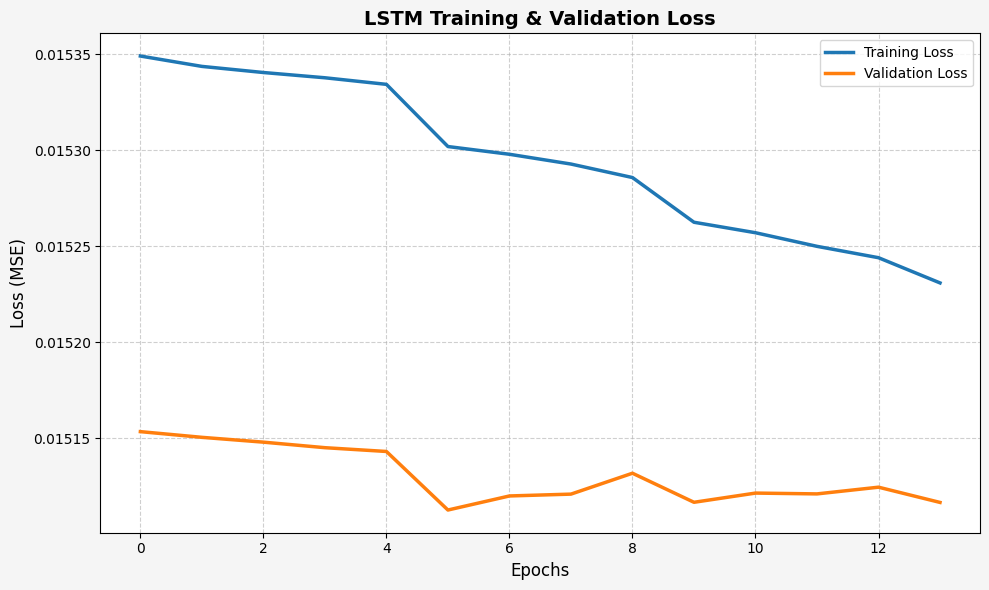

In [27]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6), facecolor="#f5f5f5")  # soft background

plt.plot(hist.history["loss"],
         label="Training Loss",
         linewidth=2.5,
         color="#1f77b4")

plt.plot(hist.history["val_loss"],
         label="Validation Loss",
         linewidth=2.5,
         color="#ff7f0e")

plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss (MSE)", fontsize=12)
plt.title("LSTM Training & Validation Loss", fontsize=14, fontweight="bold")

plt.legend(frameon=True)
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


**Plots: Example 24-hour Forecast**

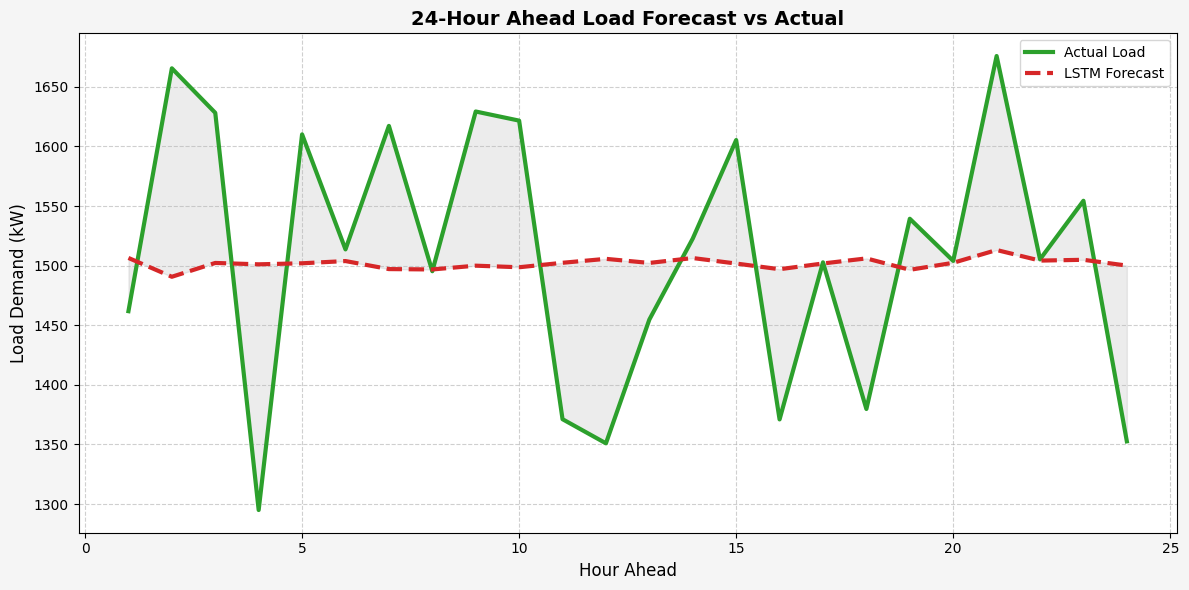

In [28]:

import numpy as np
import matplotlib.pyplot as plt

# Pick one test example (e.g., first sample)
idx = 0
hours = np.arange(1, 25)

plt.figure(figsize=(12, 6), facecolor="#f5f5f5")

plt.plot(hours, y_true[idx],
         label="Actual Load",
         linewidth=3,
         color="#2ca02c")

plt.plot(hours, lstm_pred[idx],
         label="LSTM Forecast",
         linewidth=3,
         linestyle="--",
         color="#d62728")

plt.fill_between(hours,
                 y_true[idx],
                 lstm_pred[idx],
                 color="gray",
                 alpha=0.15)

plt.xlabel("Hour Ahead", fontsize=12)
plt.ylabel("Load Demand (kW)", fontsize=12)
plt.title("24-Hour Ahead Load Forecast vs Actual", fontsize=14, fontweight="bold")

plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


**Plots: Horizon-wise MAE**

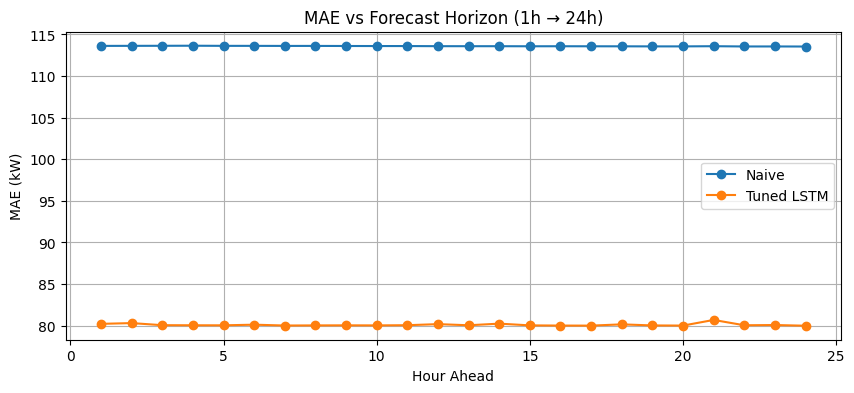

In [29]:

mae_naive_h = horizon_mae(y_true, naive_pred)

mae_lstm_h  = horizon_mae(y_true, lstm_pred)

plt.figure(figsize=(10,4))
plt.plot(range(1, HORIZON+1), mae_naive_h, marker="o", label="Naive")

plt.plot(range(1, HORIZON+1), mae_lstm_h, marker="o", label="Tuned LSTM")
plt.title("MAE vs Forecast Horizon (1h → 24h)")
plt.xlabel("Hour Ahead")
plt.ylabel("MAE (kW)")
plt.legend()
plt.grid(True)
plt.show()
